# Modeling the Spread of Covid-19 From Mobility Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from scipy.integrate import odeint

### Google Mobility Data

https://www.google.com/covid19/mobility/

According to Google, the baseline used in the mobility report is ''the median value for the corresponding day of the week, during the 5-week period Jan 3 - Feb 6, 2020.''

In [2]:
google_mobility = pd.read_csv('data/Global_Mobility_Report.csv')
# print(google_mobility.columns)
# np.unique(google_mobility.country_region)
# apple_countries = apple_mobility[apple_mobility['geo_type'] == 'country/region']

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_country_mobility(country):
    return google_mobility.iloc[np.where(google_mobility.country_region == country)]

united_states_mobility = get_country_mobility('United States')
# Names of the states (sub_region_1)
# np.unique(united_states_mobility.sub_region_1.astype('str'))

In [4]:
# Names of the counties (sub_region_2)
us_counties = np.unique(united_states_mobility.sub_region_2.astype('str'))
# len(us_counties), us_counties

In [5]:
data_columns_google = ['retail_and_recreation_percent_change_from_baseline',
                       'grocery_and_pharmacy_percent_change_from_baseline',
                       'parks_percent_change_from_baseline',
                       'transit_stations_percent_change_from_baseline',
                       'workplaces_percent_change_from_baseline',
                       'residential_percent_change_from_baseline']

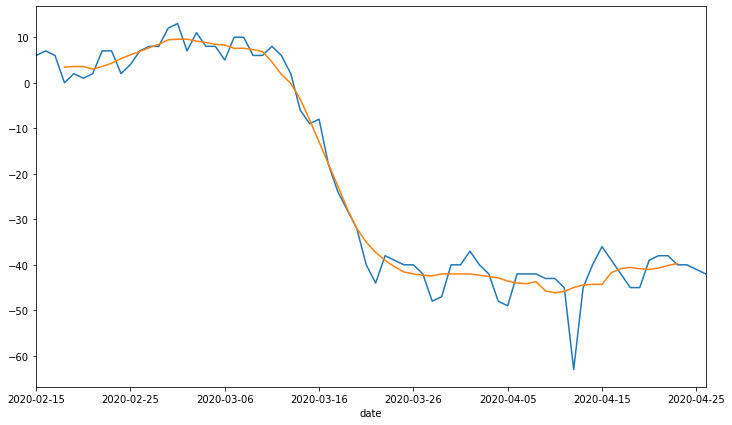

In [6]:
us_overall_google = united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == 'nan')]
us_overall_google = us_overall_google.set_index('date')
plt.figure(figsize = (12, 7))
us_overall_google.retail_and_recreation_percent_change_from_baseline.plot()

# Compute the centered 7-day rolling mean
us_overall_7d_google = us_overall_google[data_columns_google].rolling(7, center=True).mean()
# # Resample to weekly frequency, aggregating with mean
# # us_overall.index = pd.to_datetime(us_overall.index)
# # us_overall_weekly_mean = us_overall[data_columns].resample('W').mean()

# plt.figure(figsize = (12, 7))
# us_overall.retail_and_recreation_percent_change_from_baseline.plot(label = "Daily")
# # us_overall_weekly_mean.retail_and_recreation_percent_change_from_baseline.plot(label = "Weekly Mean Resample")
us_overall_7d_google.retail_and_recreation_percent_change_from_baseline.plot(label = '7-d Rolling Mean')
# plt.legend(loc = 'best')
# plt.show()

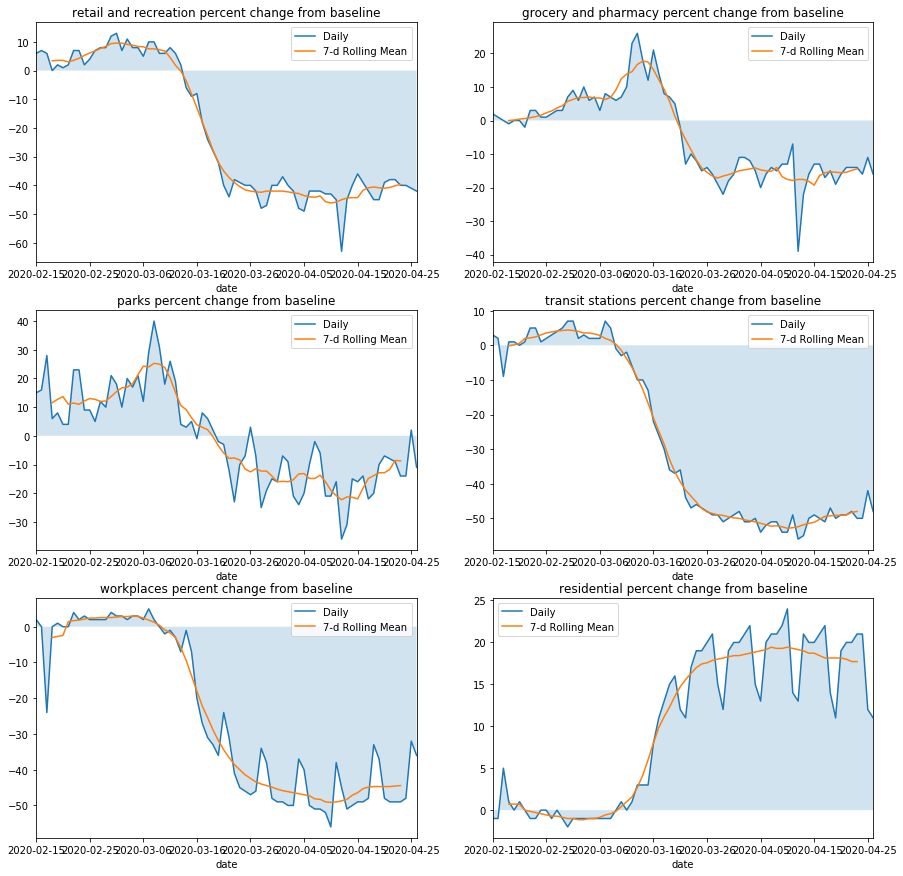

In [7]:
def plot_daily_rolling(df, col_name_lst):
    rolling_7d = df[col_name_lst].rolling(7, center=True).mean()
    
    fig, axes = plt.subplots(round(len(col_name_lst) / 2), 2, figsize = (15, 15))
    for i, col_name in enumerate(col_name_lst):
        df[col_name].plot(label = "Daily", ax = axes[i // 2][i % 2])
        rolling_7d[col_name].plot(label = '7-d Rolling Mean', ax = axes[i // 2][i % 2])
        axes[i // 2][i % 2].fill_between(df.index, 0, df[col_name], alpha = 0.2)
        axes[i // 2][i % 2].set_title(col_name.replace('_', " "))
        axes[i // 2][i % 2].legend(loc = 'best')
        
    plt.show()

        
plot_daily_rolling(us_overall_google, data_columns_google)


In [8]:
# np.unique(united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == 'Washington')].sub_region_2.astype('str'))

In [9]:
def get_county(state, county):
    all_counties = united_states_mobility.iloc[np.where(united_states_mobility.sub_region_1.astype('str') == state)]
    county_overall = all_counties.iloc[np.where(all_counties.sub_region_2.astype('str') == county)]
    county_overall = county_overall.set_index('date')
    return county_overall

def get_state_overall(state):
    return get_county(state, 'nan')

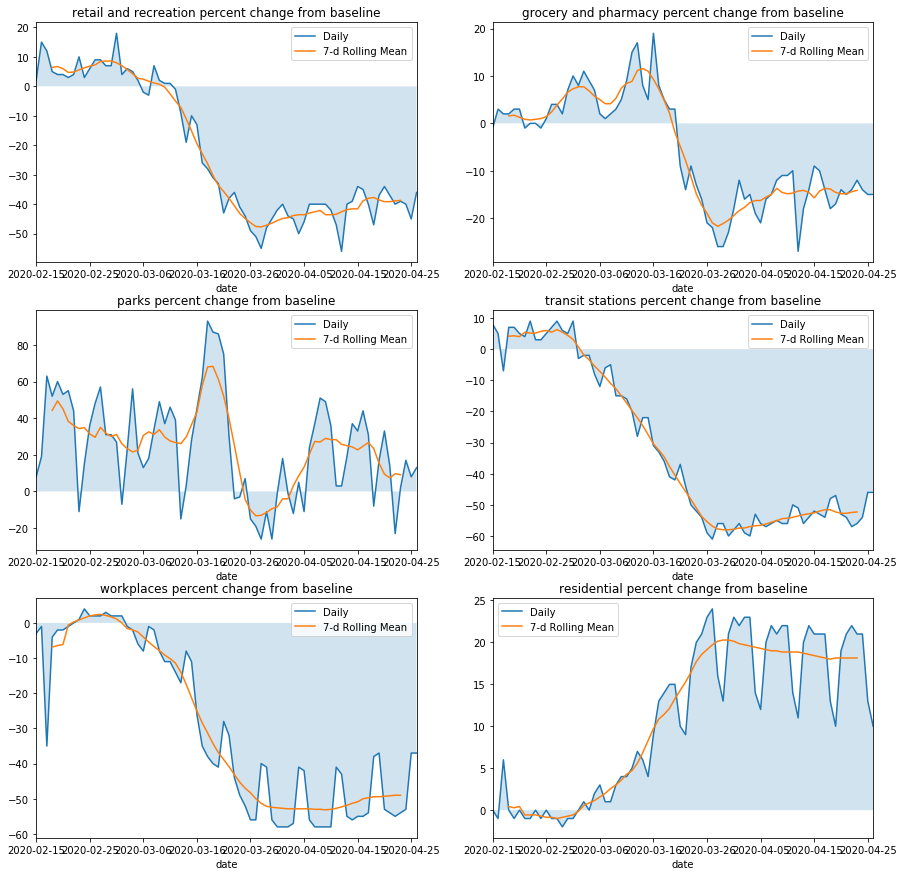

In [10]:
wa_overall = get_state_overall('Washington')
plot_daily_rolling(wa_overall, data_columns_google)

### Apple Mobility Data

https://www.apple.com/covid19/mobility

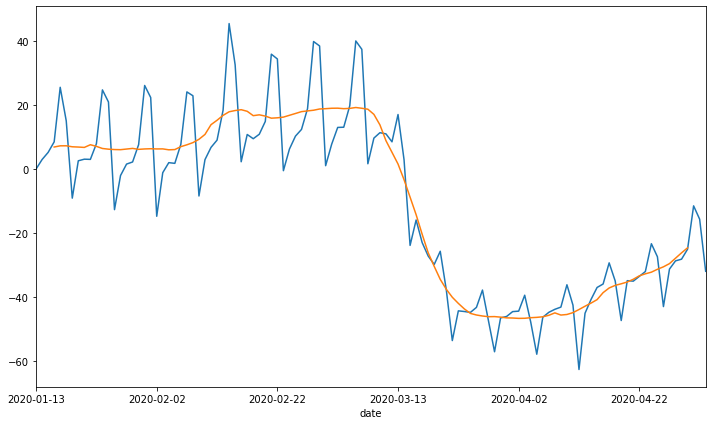

In [11]:
apple_mobility = pd.read_csv('data/applemobilitytrends-2020-05-03.csv') # will need to change this
apple_us = apple_mobility[apple_mobility['region'] == 'United States']

# NECESSARY DATA WRANGLING

data_columns_apple = ['driving', 'transit', 'walking']

apple_us_total = apple_us[apple_us['geo_type'] == 'country/region']
transposed_apple = apple_us_total.drop(columns=['geo_type', 'region', 'alternative_name']).T
transposed_apple = transposed_apple.reset_index().rename(columns={'index': 'date', 146: 'driving', 147: 'transit', 148:'walking'}).iloc[1:]
transposed_apple[data_columns_apple] = transposed_apple[data_columns_apple].astype('float64')
transposed_apple = transposed_apple.set_index('date')

# centering to reflect how the google mobility data is structured
transposed_apple = transposed_apple - 100

us_overall_7d_apple = transposed_apple[data_columns_apple].rolling(7, center=True).mean()

plt.figure(figsize = (12, 7))
transposed_apple.driving.plot()
us_overall_7d_apple.driving.plot()


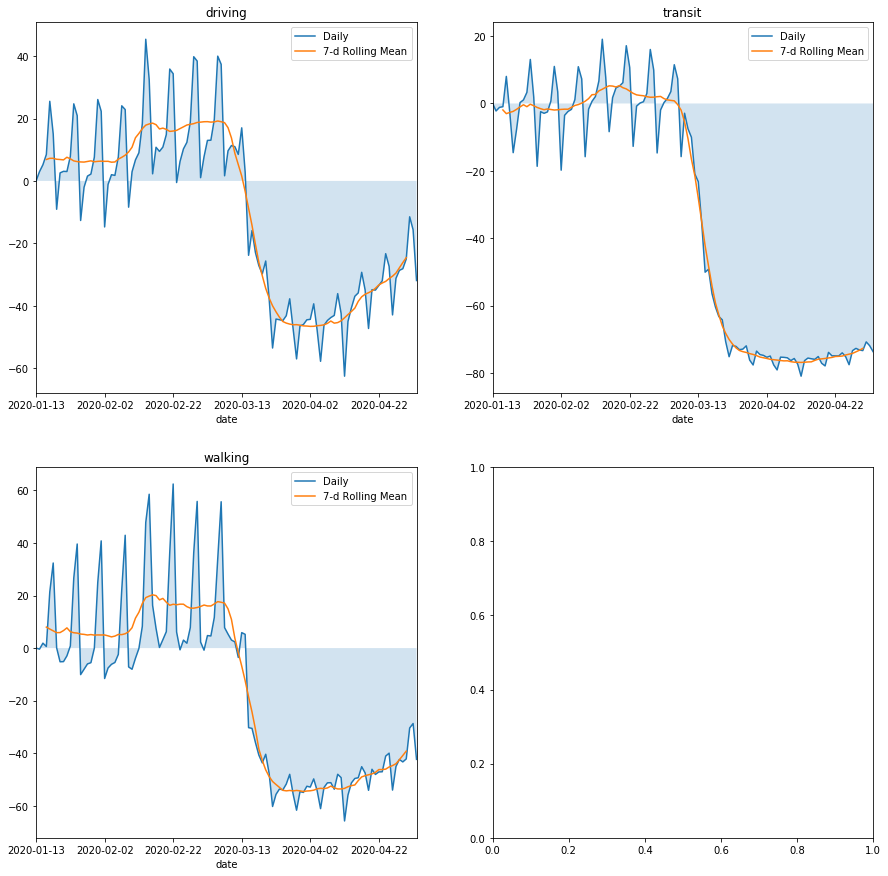

In [12]:
plot_daily_rolling(transposed_apple, data_columns_apple)

# SIR Model with Modifications

Basic SIR model: https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

Variables in the SIR model:

- **N:** total population
- **S(t):** number of people susceptible on day *t*
- **E(t):** number of people exposed on day *t*
- **I(t):** number of people infected on day *t*
- **R(t):** number of people recovered on day *t*
- **D(t):** number of people dead on day *t*
- **$\mathbf{\beta}$:** expected amount of people an infected person infects per day
- **D:** number of days an infected person has and can spread the disease
- **$\mathbf{\gamma}$:** the proportion of infected recovering per day ($\gamma = 1 / D$)
- **R$_0$:** the total number of people an infected person infects ($R_0 = \beta / \gamma$)
- **$\mathbf{\delta}$:** length of incubation period
- **$\mathbf{\alpha}$:** fatality rate
- **$\mathbf{\rho}$:** rate at which people die ($\rho = 1 / $ days from infected until death)

Plotting functions:

In [11]:
def plotseird(t, S, E, I, R, D):
    '''
    Plot the SIR model defined by the S (susceptible), E (exposed), I (infected), R (recovered), D (dead) arrays 
    '''
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
#     ax.axhline(1.12 * 10**6, t[0], t[-1], color = 'r', alpha=0.7, linewidth=1, label='current infected estimate')
#     ax.axhline(69171, t[0], t[-1], color = 'black', alpha=0.7, linewidth=1, label='current death estimate')
#     ax.axvline(104, 0, 2 * 10**6, color = 'cornflowerblue', alpha=0.7, linewidth=1, label='current day')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
#     ax.set_ylim((0, 2 * 10**6))
    plt.show();

In [12]:
def plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    '''
    Plot two SIR models
    '''
    f, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax.plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax.plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax.plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax.plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax.plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

In [13]:
def plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D):
    '''
    Plots subplots of each curve to observe difference between original and adjusted model
    '''
    f, ax = plt.subplots(3,2,figsize=(20,17))
    ax[2, 0].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 0].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[0, 0].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[0, 0].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[0, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[0, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[1, 0].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[1, 0].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[1, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[1, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')

    ax[2, 1].plot(t, S_orig, 'b', alpha=0.2, linewidth=1, label='Susceptible Original')
    ax[2, 1].plot(t, E_orig, 'y', alpha=0.2, linewidth=1, label='Exposed Original')
    ax[2, 1].plot(t, I_orig, 'r', alpha=0.2, linewidth=1, label='Infected Original')
    ax[2, 1].plot(t, R_orig, 'g', alpha=0.2, linewidth=1, label='Recovered Original')
    ax[2, 1].plot(t, D_orig, 'k', alpha=0.2, linewidth=1, label='Dead Original')
    ax[2, 1].plot(t, S_orig+E_orig+I_orig+R_orig+D_orig, 'c--', alpha=0.2, linewidth=1, label='Total Original')
    
    ax[2, 1].plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible New Model')
    ax[2, 1].plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed New Model')
    ax[2, 1].plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected New Model')
    ax[2, 1].plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered New Model')
    ax[2, 1].plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead New Model')
    ax[2, 1].plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    
    
    for a in ax:  
        for i in range(2):
            a[i].set_xlabel('Time (days)')
            a[i].yaxis.set_tick_params(length=0)
            a[i].xaxis.set_tick_params(length=0)
            a[i].grid(b=True, which='major', c='w', lw=2, ls='-')
            legend = a[i].legend()
            legend.get_frame().set_alpha(0.5)
            for spine in ('top', 'right', 'bottom', 'left'):
                a[i].spines[spine].set_visible(False)
    plt.show();

SIR model definition:

In [14]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    '''
    Find the derivatives necessary to calculate the SIR model changes
    '''
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def deriv_original(y, t, N, beta, gamma, delta, alpha, rho):
    '''
    Find the derivatives necessary to calculate the SIR model changes (when beta is constant)
    '''
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [17]:
# Thoughts for Google Mobility data coefs
# Retail recreation - negative, harder to social distance
# Grocery pharmacy - negative, easier to social distance
# Parks - neutral, easier to social distance
# Transit stations - negative, harder to social distance
# Workplaces - negative, harder to social distance
# Residential - positive, social distanced
# R_0_change = (-)rr_coef * (% change from baseline) + (-)gp_coef * (% change from baseline) 
#            + (-)p_coef * (% change from baseline) + (-)ts_coef * (% change from baseline) 
#            + (-)w_coef * (% change from baseline) + (+)r_coef * (% change from baseline)
# negative coef ranking: rr_coef >= ts_coef >= w_coef > gp_coef >= p_coef

SIR model coefficient estimates:

In [15]:
################### SIR COEFFICIENT ESTIMATES FROM EXTERNAL SCHOLARLY WORK ###################
N = 328.2 * 10**6 # Total population
# https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus
# mild infection seems to last one - two weeks, typically infectious 48 - 72 hours before showing symptoms
D = 14.0
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

# initial R_0 estimate https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
initial_r_0 = 5.7

# according to this a 3% death rate is more reasonable https://www.worldometers.info/coronavirus/coronavirus-death-rate/
alpha = 0.03 # 0.14  # 14% death rate (estimated from current worldwide statistics, we are taking the lower estimate 
# because there are probably a lot of asymptomatic cases that are not identified)
rho = 1/14 # 1 / 9  # 9 days from infection until death
###################

# Needs to be tuned
google_weights = [-1, -0.5, -0.5, -1, -1, 2]

# day 0 = January 21, first day of Google mobility 7d rolling is Feb 18, 28 days later

SIR model functions (for $R_0$ and $\beta$):

In [16]:
def R_0(t, initial_r_0, coefs, mobility_df, data_columns):
    '''
    Uses U.S. mobility data as a proxy to find the adjusted R_0 value for Covid-19 in the U.S.
    
    t: time, integer value starting from 0 where 0 = January 21, 2020
    initial_r_0: the initial R_0 value (estimated from https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)
    coefs: the weights for each type of mobility category
    mobility_df: the mobility dataframe (shows percent change from baseline value)
    data_columns: the mobility categories
    
    returns: an adjusted R_0 value
    '''
    
    mobility_df = mobility_df.dropna()

    r_0 = initial_r_0
    r_0_change = 0
    # First day recorded, last day recorded
    # TODO - change hardcoded numbers to match model
    max_data_idx = len(mobility_df) - 1
    
    # Match the mobility data time scale to the model time scale 
    # (this will need to be adjusted with the forecasted mobility models)
    data_idx_delta = (pd.to_datetime('2020-01-21') - pd.to_datetime(mobility_df.iloc[0].name)).days
    adjusted_t = int(t + data_idx_delta)
    if adjusted_t >= 0 and adjusted_t <= max_data_idx:
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_df.iloc[adjusted_t][col] / 100
        r_0 -= r_0_change
#         print(max(r_0, 0))
    elif adjusted_t > max_data_idx:
        ## TODO - add the forecasted model here (elif becomes else and value is drawn from forecasted model)
        for coef, col in zip(coefs, data_columns):
            r_0_change += coef * mobility_df.iloc[max_data_idx][col] / 100
        r_0 -= r_0_change
    return max(r_0, 0) 

# for t in range(0, 120):
#     R_0(t, 5.7, [-1, -1, -1], us_overall_7d, data_columns_google)

def beta_google(t):
    return R_0(t, initial_r_0, google_weights, us_overall_7d_google, data_columns_google) * gamma

In [17]:
# initial conditions: one exposed
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  
y0 = S0, E0, I0, R0, D0 

# Grid of time points (in days), observe a one year period
t = np.linspace(0, 365, 366) 

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_google, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

Social Distancing, (Google mobility data for R_0 proxy)


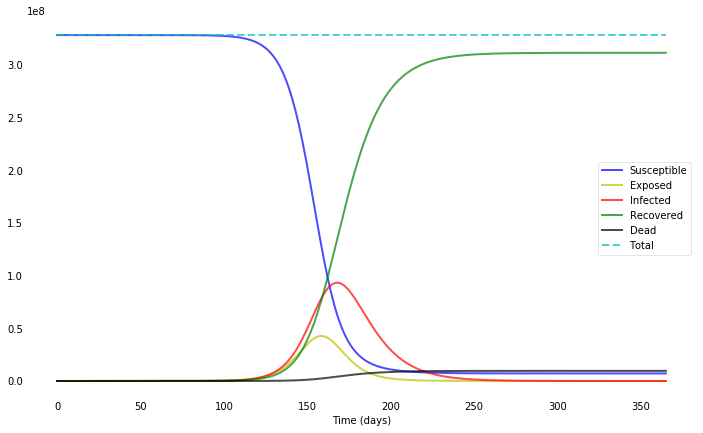

In [18]:
print("Social Distancing, (Google mobility data for R_0 proxy)")
plotseird(t, S, E, I, R, D)

In [19]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_original, y0, t, args=(N, 5.7 * gamma, gamma, delta, alpha, rho))
S_orig, E_orig, I_orig, R_orig, D_orig = ret.T

No Social Distancing, (R_0 stays constant at 5.7)


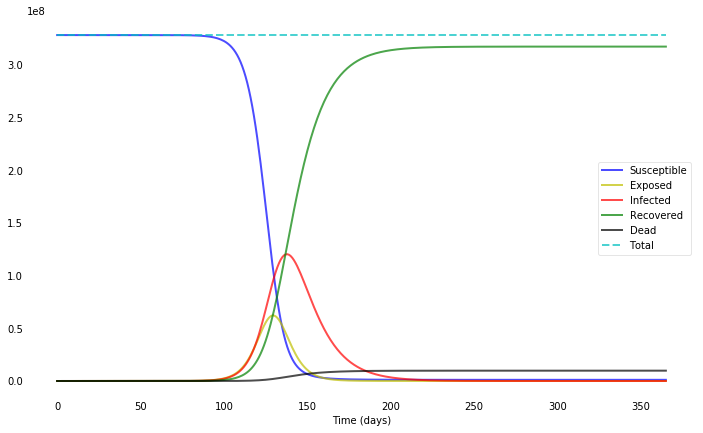

In [20]:
print("No Social Distancing, (R_0 stays constant at 5.7)")
plotseird(t, S_orig, E_orig, I_orig, R_orig, D_orig)

Google mobility model overlayed with original model


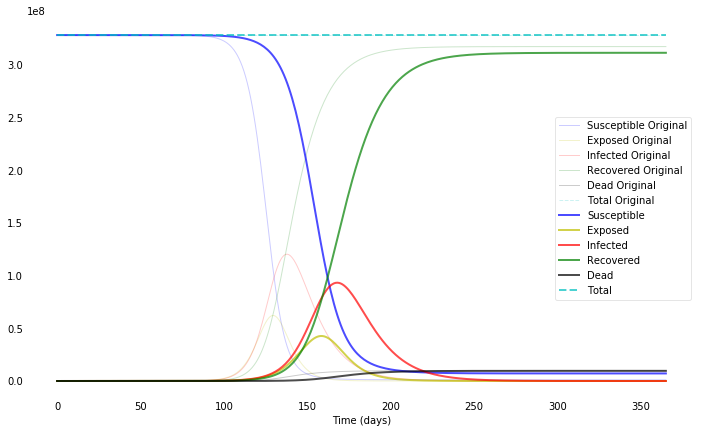

In [21]:
print("Google mobility model overlayed with original model")
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

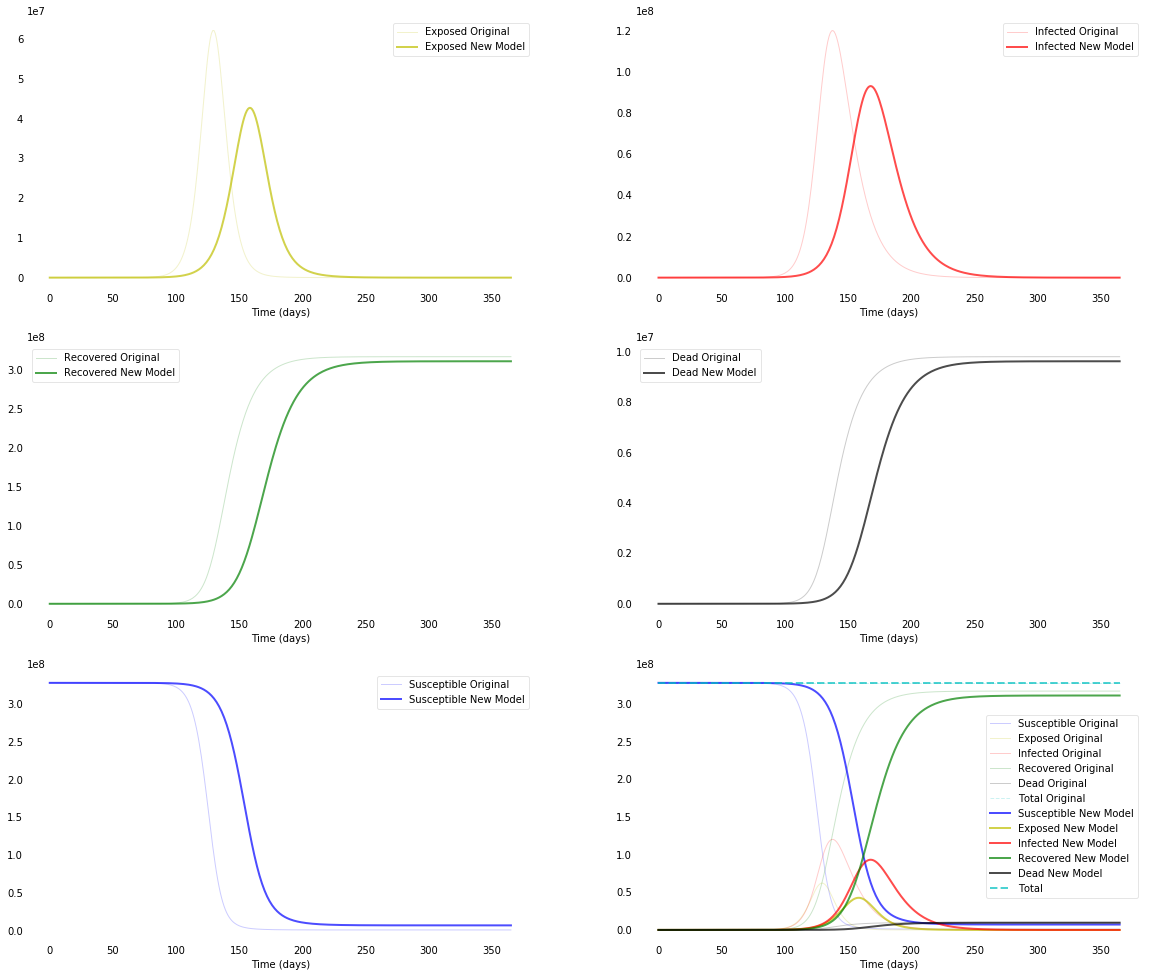

In [22]:
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

## Apple Mobility Data SIR

In [26]:
# THIS IS WHERE YOU TUNE PARAMETERS
apple_weights = [-1, -1, -1]

def beta_apple(t):
    return R_0(t, 5.7, apple_weights, us_overall_7d_apple, data_columns_apple) * gamma

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_apple, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

Social Distancing, (Apple mobility data for R_0 proxy)


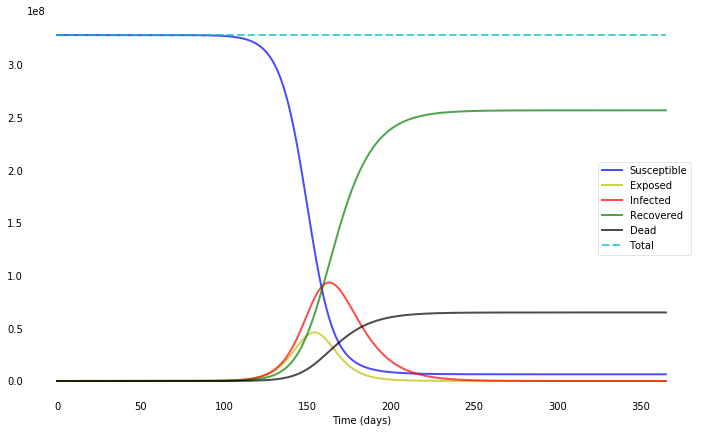

In [27]:
print("Social Distancing, (Apple mobility data for R_0 proxy)")
plotseird(t, S, E, I, R, D)

Apple mobility model overlayed with original model


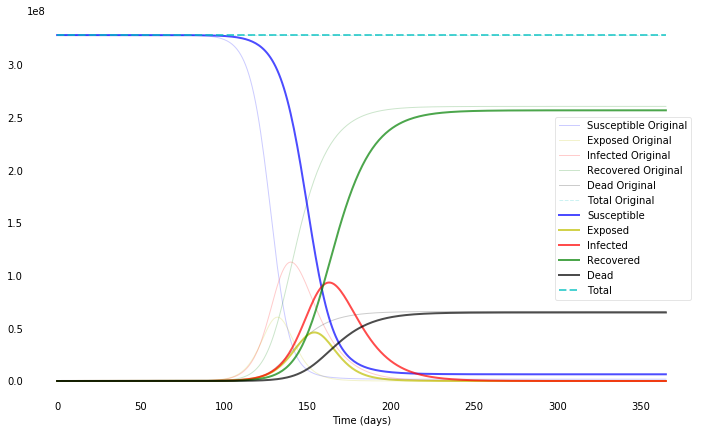

In [28]:
print("Apple mobility model overlayed with original model")
plotseird_both(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

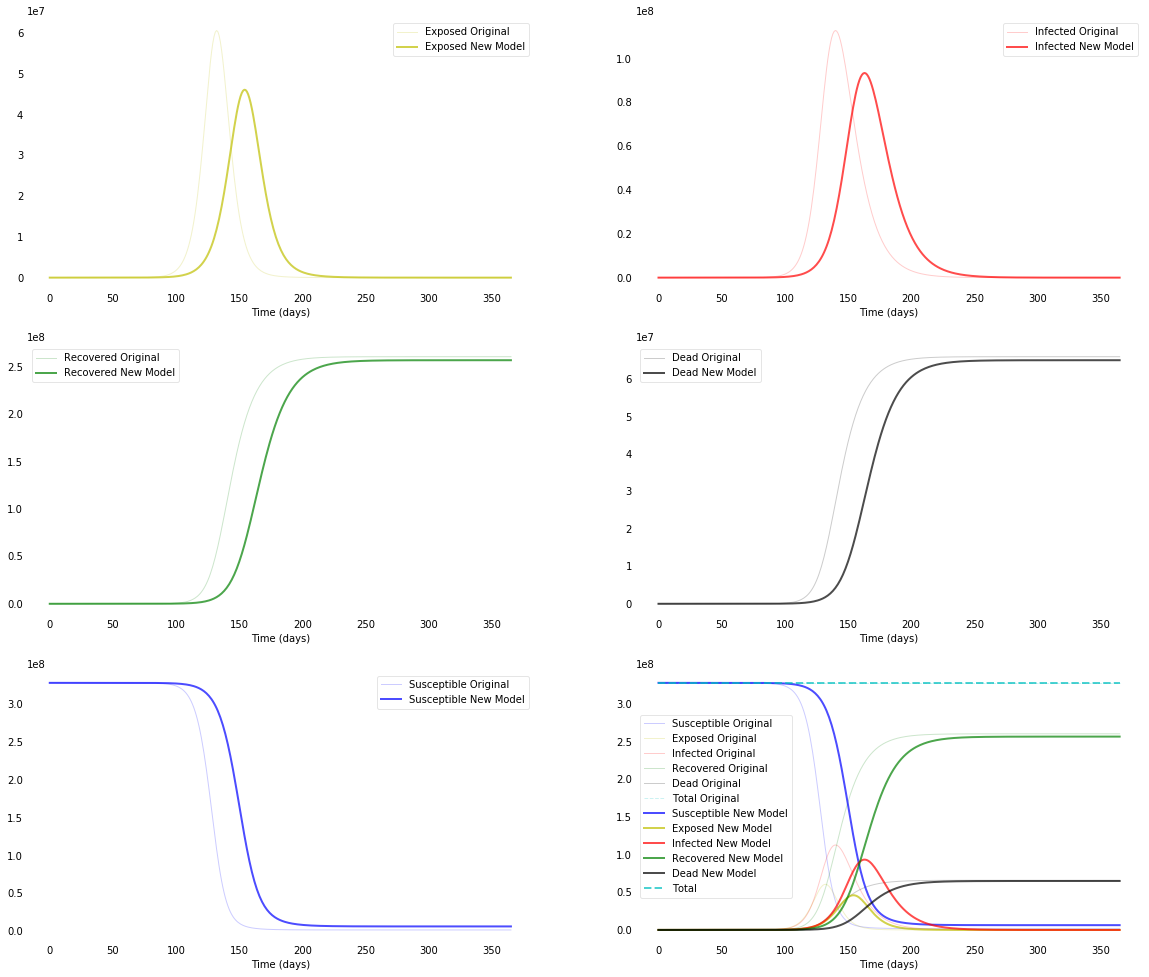

In [29]:
plotseird_both_subplots(t, S_orig, E_orig, I_orig, R_orig, D_orig, S, E, I, R, D)

## Model ideas

- Time series forecasting to extend the mobility data to predict/model the future and past
- Fine tune the parameter values
- Further adjust the $R_0$ function (maybe some type of logistic or dependent on past $R_0$)
- Add resource and age dependent fatality rates